# Dimension Estimation and Kernel PCA

## MNIST Digits

We use data form https://www.kaggle.com/c/digit-recognizer/data. We use subsamples to spead up calculations.

In [1]:
# import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# set matplotlib to display all plots inline with the notebook
%matplotlib inline

In [2]:
# load train data, eliminate class labels, plot first point as a digit
#load train data
train = pd.read_csv('./data/train.csv')
#eliminate class labels
train = train.drop("label",axis=1)
train.head()


,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


(42000, 784)


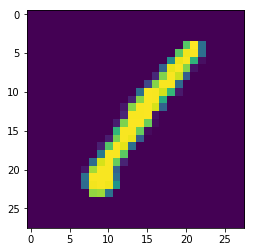

In [3]:
train_arr = np.array(train)
print(train_arr.shape)
plt.imshow(train_arr[0, :].reshape(28, 28))

In [4]:
"""
Implementation of 'Maximum Likelihood Estimation of Intrinsic Dimension' by Elizaveta Levina and Peter J. Bickel
 
how to use
----------
 
The goal is to estimate intrinsic dimensionality of data, the estimation of dimensionality is scale dependent
(depending on how much you zoom into the data distribution you can find different dimesionality), so they
propose to average it over different scales, the interval of the scales [k1, k2] are the only parameters of the algorithm.
 
This code also provides a way to repeat the estimation with bootstrapping to estimate uncertainty.
 
Here is one example with swiss roll :
 
from sklearn.datasets import make_swiss_roll
X, _ = make_swiss_roll(1000)
 
k1 = 10 # start of interval(included)
k2 = 20 # end of interval(included)
intdim_k_repeated = repeated(intrinsic_dim_scale_interval, 
                             X, 
                             mode='bootstrap', 
                             nb_iter=500, # nb_iter for bootstrapping
                             k1=k1, k2=k2)
intdim_k_repeated = np.array(intdim_k_repeated)
# the shape of intdim_k_repeated is (nb_iter, size_of_interval) where 
# nb_iter is number of bootstrap iterations (here 500) and size_of_interval
# is (k2 - k1 + 1).
 
# Plotting the histogram of intrinsic dimensionality estimations repeated over
# nb_iter experiments
plt.hist(intdim_k_repeated.mean(axis=1))
 
"""
# from tqdm import tqdm
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
%matplotlib inline
import math
import sys
import os

 
def intrinsic_dim_sample_wise(X, k=5):
    neighb = NearestNeighbors(n_neighbors=k+1).fit(X)
    dist, ind = neighb.kneighbors(X)
    dist = dist[:, 1:]
    dist = dist[:, 0:k]
    assert dist.shape == (X.shape[0], k)
    assert np.all(dist > 0)
    d = np.log(dist[:, k - 1: k] / dist[:, 0:k-1])
    d = d.sum(axis=1) / (k - 2)
    d = 1. / d
    intdim_sample = d
    return intdim_sample
 
def intrinsic_dim_scale_interval(X, k1=10, k2=20):
    X = pd.DataFrame(X).drop_duplicates().values # remove duplicates in case you use bootstrapping
    intdim_k = []
    for k in range(k1, k2 + 1):
        m = intrinsic_dim_sample_wise(X, k).mean()
        intdim_k.append(m)
    return intdim_k
 
def repeated(func, X, nb_iter=100, random_state=None, mode='bootstrap', **func_kw):
    if random_state is None:
        rng = np.random
    else:
        rng = np.random.RandomState(random_state)
    nb_examples = X.shape[0]
    results = []
 
    iters = range(nb_iter) 
    for i in iters:
        if mode == 'bootstrap':
            Xr = X[rng.randint(0, nb_examples, size=nb_examples)]
        elif mode == 'shuffle':
            ind = np.arange(nb_examples)
            rng.shuffle(ind)
            Xr = X[ind]
        elif mode == 'same':
            Xr = X
        else:
            raise ValueError('unknown mode : {}'.format(mode))
        results.append(func(Xr, **func_kw))
    return results

In [5]:
# Maximum Likelihood Estimation of Intrinsic Dimension 

print(np.shape(train_arr))

k1 = 10 # start of interval(included)
k2 = 20 # end of interval(included)
nb_iter = 2

intdim_k_repeated = repeated(intrinsic_dim_scale_interval, 
                             train_arr[1:2000], 
                             mode='bootstrap', 
                             nb_iter=nb_iter, # nb_iter for bootstrapping 
                             k1=k1, k2=k2)
intdim_k_repeated = np.array(intdim_k_repeated)

(42000, 784)


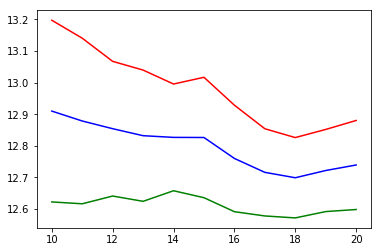

In [6]:
plt.plot(range(k1, k2 + 1), np.mean(intdim_k_repeated, axis=0), 'b')
plt.plot(range(k1, k2 + 1), np.mean(intdim_k_repeated, axis=0) + np.std(intdim_k_repeated, axis=0), 'r')
plt.plot(range(k1, k2 + 1), np.mean(intdim_k_repeated, axis=0) - np.std(intdim_k_repeated, axis=0), 'g')

In [7]:
# apply kernel PCA to the train data (see Seminar04): 
# We plot reduction-reconstrucion error as a function of the reduced space dimensionality
# Then, we provide recommendations for the kernel PCA reduced space dimension
# plot results of the reduction-reconstrucion for a fixed digit and different dimensions

from sklearn.decomposition import KernelPCA

intrisic_dim = 13

X = train_arr[0:2000]
dimensions = np.array(range(intrisic_dim - 3, intrisic_dim + 110, 10)) 



In [8]:
# defining reduction-reconstrucion error
def get_ml_quality(X, X_rec):
    return 1 - np.mean(np.sum((X - X_rec)**2, axis=1), axis=0) / np.mean(np.sum((X - np.mean(X, axis=0))**2, axis=1), axis=0)

In [9]:
#Calculate

explained_variance=np.zeros(len(dimensions))
index = 0
for dim in dimensions:
    scikit_kpca = KernelPCA(n_components=dim, kernel = "rbf", gamma=15, fit_inverse_transform = True, n_jobs = -1)
    scikit_kpca.fit(X)
    X_kpca = scikit_kpca.transform(X)
    X_rec = scikit_kpca.inverse_transform(X_kpca)
    explained_variance[index] = get_ml_quality(X, X_rec)
    index += 1
    print('current_dim = ' + str(dim))

current_dim = 10
current_dim = 20
current_dim = 30
current_dim = 40
current_dim = 50
current_dim = 60
current_dim = 70
current_dim = 80
current_dim = 90
current_dim = 100
current_dim = 110
current_dim = 120


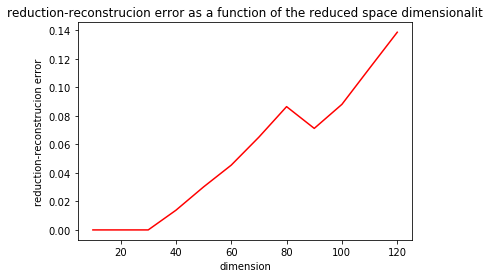

In [10]:
plt.plot(dimensions, explained_variance, 'r')
plt.title('reduction-reconstrucion error as a function of the reduced space dimensionalit')
plt.ylabel('reduction-reconstrucion error')
plt.xlabel('dimension')

In [12]:
# ignore warning 

import warnings
def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

# plot results of the reduction-reconstrucion for a fixed digit and different dimensions
# for Kernel: Poly
explained_variance_poly = np.zeros(len(dimensions))

point_rec = []
point_index = 5
point2_rec = []
point2_index = 10
index = 0
for dim in dimensions:
    gamma = 15
    scikit_kpca = KernelPCA(n_components=dim, kernel = "poly", degree = 2, fit_inverse_transform = True, n_jobs = -1)
    scikit_kpca.fit(X)
    X_kpca = scikit_kpca.transform(X)
    X_rec = scikit_kpca.inverse_transform(X_kpca)
    point_rec.append(X_rec[point_index, :])
    point2_rec.append(X_rec[point2_index, :])
    explained_variance_poly[index] = get_ml_quality(X, X_rec)
    index += 1
    print('current_dim = ' + str(dim))

/home/kumar/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 9.617618966089139e-20
  ' condition number: {}'.format(rcond), RuntimeWarning)


current_dim = 10


/home/kumar/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 5.76699339122455e-19
  ' condition number: {}'.format(rcond), RuntimeWarning)


current_dim = 20


/home/kumar/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.7927575047657234e-18
  ' condition number: {}'.format(rcond), RuntimeWarning)


current_dim = 30


/home/kumar/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 6.107733588331112e-18
  ' condition number: {}'.format(rcond), RuntimeWarning)


current_dim = 40


/home/kumar/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 2.350129563489491e-17
  ' condition number: {}'.format(rcond), RuntimeWarning)


current_dim = 50
current_dim = 60
current_dim = 70
current_dim = 80
current_dim = 90
current_dim = 100
current_dim = 110
current_dim = 120


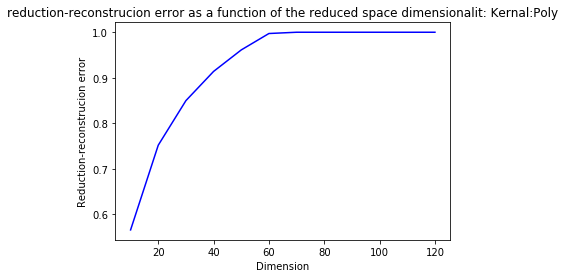

In [13]:
plt.plot(dimensions, explained_variance_poly, 'b')
plt.title('reduction-reconstrucion error as a function of the reduced space dimensionalit: Kernal:Poly')
plt.ylabel('Reduction-reconstrucion error')
plt.xlabel('Dimension')

In [14]:
# provides recommendations for the kernel PCA reduced space dimension

High high reconstruction accuracy demands intrenic dimension of minimum 60. Its confirmed by kernal:poly. But earlier, it was 13. We can't deny possibility of overestimation.

In [15]:
def make_image_plot(point_array):
    image = np.zeros((28, 28))

    for x in range(0, np.size(point_array)):
        row = np.floor_divide(x, 28)
        column = np.remainder(x, 28)
        image[row, column] = point_array[x]

    plt.gray() 
    plt.matshow(image)
    plt.show() 

In [16]:
# plot results of the reduction-reconstrucion for a fixed digit and different dimensions

Original image


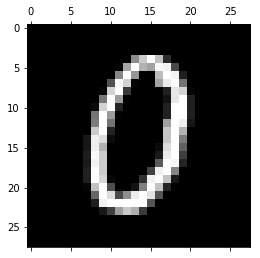

reduction-reconstructed image and Dimension = 10


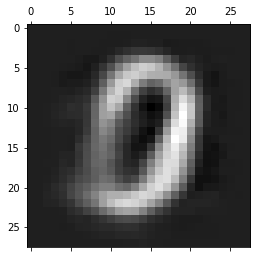

reduction-reconstructed image and Dimension = 20


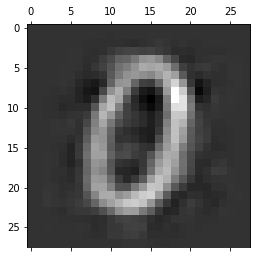

reduction-reconstructed image and Dimension = 30


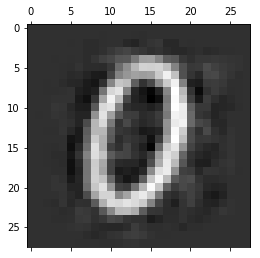

reduction-reconstructed image and Dimension = 40


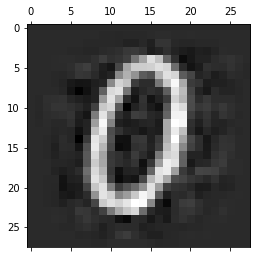

reduction-reconstructed image and Dimension = 50


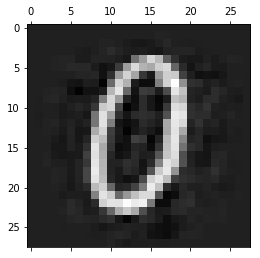

reduction-reconstructed image and Dimension = 60


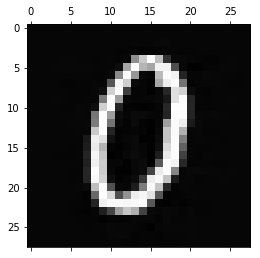

reduction-reconstructed image and Dimension = 70


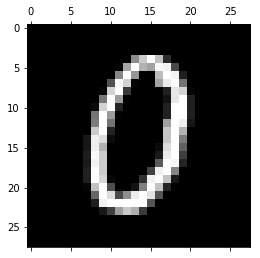

reduction-reconstructed image and Dimension = 80


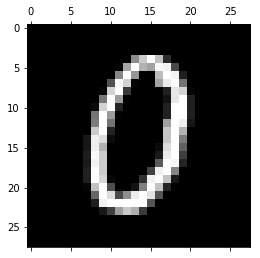

reduction-reconstructed image and Dimension = 90


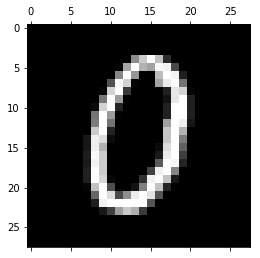

reduction-reconstructed image and Dimension = 100


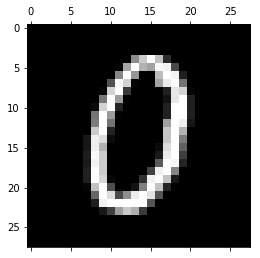

reduction-reconstructed image and Dimension = 110


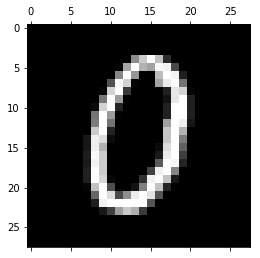

reduction-reconstructed image and Dimension = 120


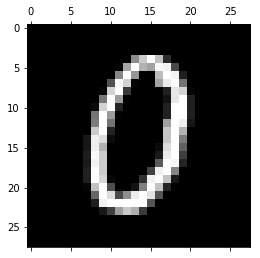

In [17]:
print('Original image')
make_image_plot(X[point_index, :])

index = 0
for dim in dimensions:
    print('reduction-reconstructed image and Dimension = ' + str(dim))
    make_image_plot(np.asarray(point_rec[index]))
    index += 1